## BT4222 Project ML Models

### 1. Importing Libraries and Dataset

In [124]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import statsmodels as sm
import seaborn as sns
import matplotlib
import six
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [125]:
# read the data
df = pd.read_csv('full_data.csv')
df.head()

,Unnamed: 0,id,Song title,Artist,Current Ranking,Number of weeks on billboard,Peak Ranking,Date,Danceability,Energy,...,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration ms,Time Signature,Artist Score
0,0,1,All I Want For Christmas Is You,Mariah Carey,1,17,1,2022-01-01,0.837,0.462,...,1.0,0.0601,0.033900,0.000000,0.0900,0.762,139.986,201400.0,4.0,79.0
1,1,2,Last Christmas,Wham!,2,15,2,2022-01-01,0.801,0.737,...,1.0,0.0885,0.000505,0.946000,0.1030,0.840,110.052,226720.0,4.0,22.0
2,2,3,Rockin' Around The Christmas Tree,Brenda Lee,3,13,3,2022-01-01,0.466,0.416,...,1.0,0.0260,0.742000,0.000005,0.2490,0.516,98.780,171227.0,3.0,58.0
3,3,4,Jingle Bell Rock,Bobby Helms,4,13,4,2022-01-01,0.754,0.424,...,1.0,0.0363,0.643000,0.000000,0.0652,0.806,119.705,130973.0,4.0,48.0
4,4,5,abcdefu,GAYLE,5,6,2,2022-01-01,0.695,0.540,...,1.0,0.0493,0.299000,0.000000,0.3670,0.415,121.932,168602.0,4.0,69.0


### 2 Exploratory Data Analysis

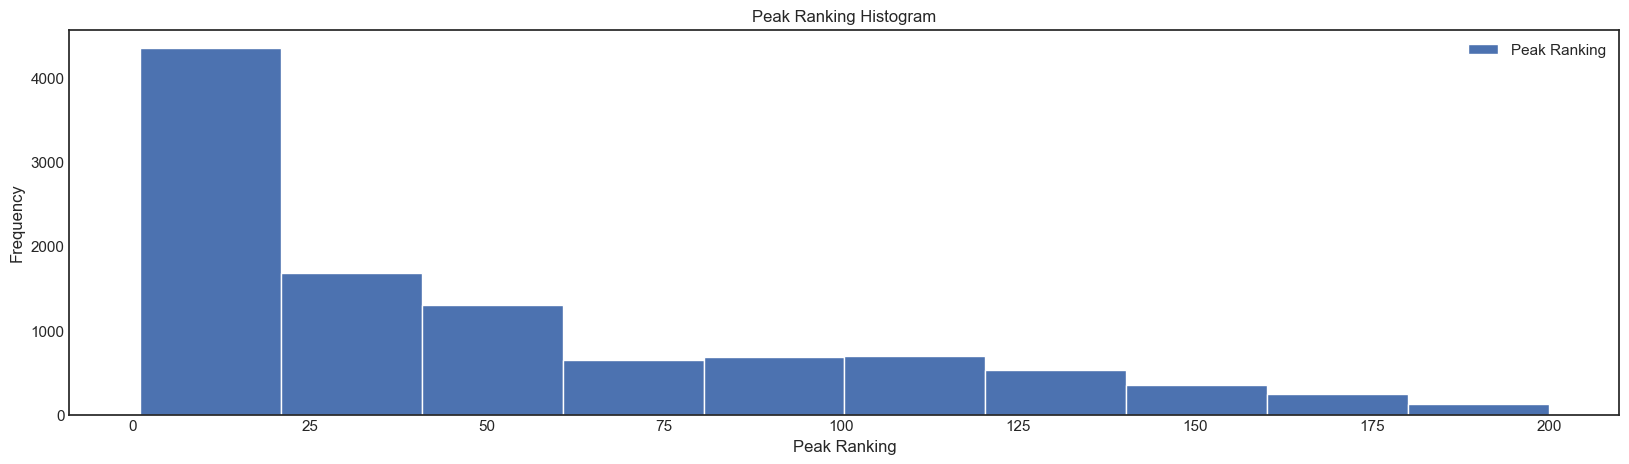

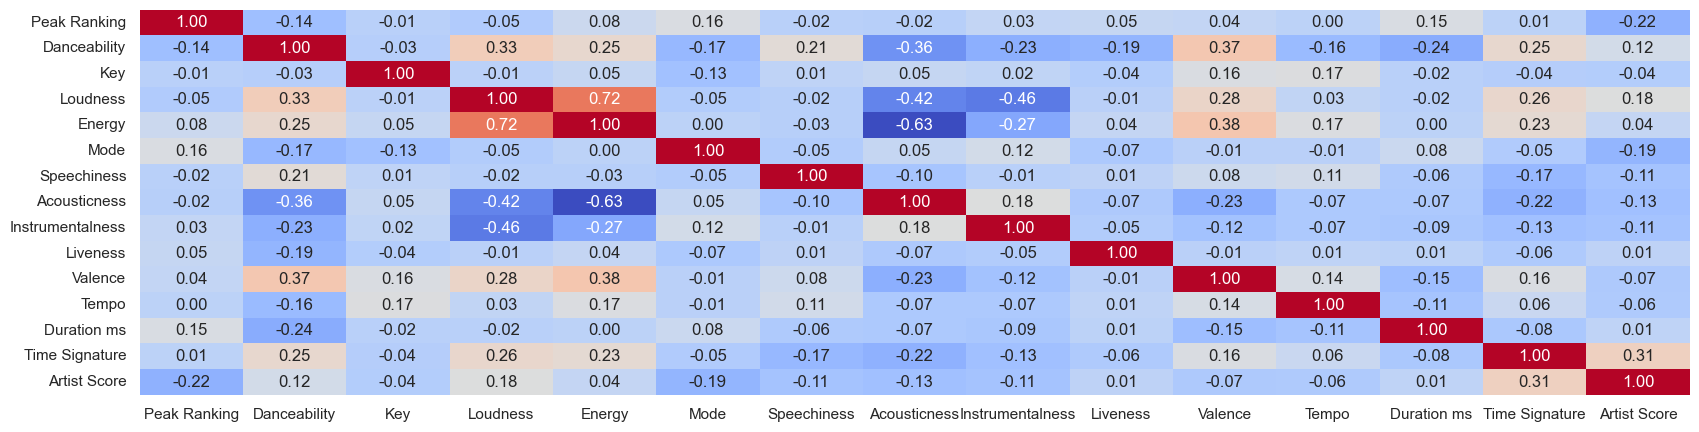

In [126]:
plt.style.use("seaborn-v0_8-white")
peak = df.plot.hist(y='Peak Ranking')

# Set the title and labels of the plot
peak.set_title('Peak Ranking Histogram')
peak.set_xlabel('Peak Ranking')
peak.set_ylabel('Frequency')

# Show the peak ranking histogram

plt.savefig('Peak Ranking Hist.png', transparent = True, pad_inches = 0.1)
plt.show()

# From the histogram shown, we need to perfom binning

variable_list = ['Peak Ranking',
        'Danceability', 'Key', 'Loudness', 'Energy', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo', 'Duration ms', 'Time Signature','Artist Score']

# Plot Correlation Matrix
# corr = df[variable_list].corr()
# corr.style.background_gradient(cmap='coolwarm')
sns.set(rc={"figure.figsize":(20, 5)})
fig, ax = plt.subplots()
sns.heatmap(df[variable_list].corr(method='pearson'), annot=True, fmt='.2f', 
            cmap=plt.get_cmap('coolwarm'), cbar=False, ax=ax)
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_xticklabels(ax.get_xticklabels(), rotation="horizontal")
plt.savefig('Corr Matrix.png', bbox_inches='tight', pad_inches=0.5, transparent = True)

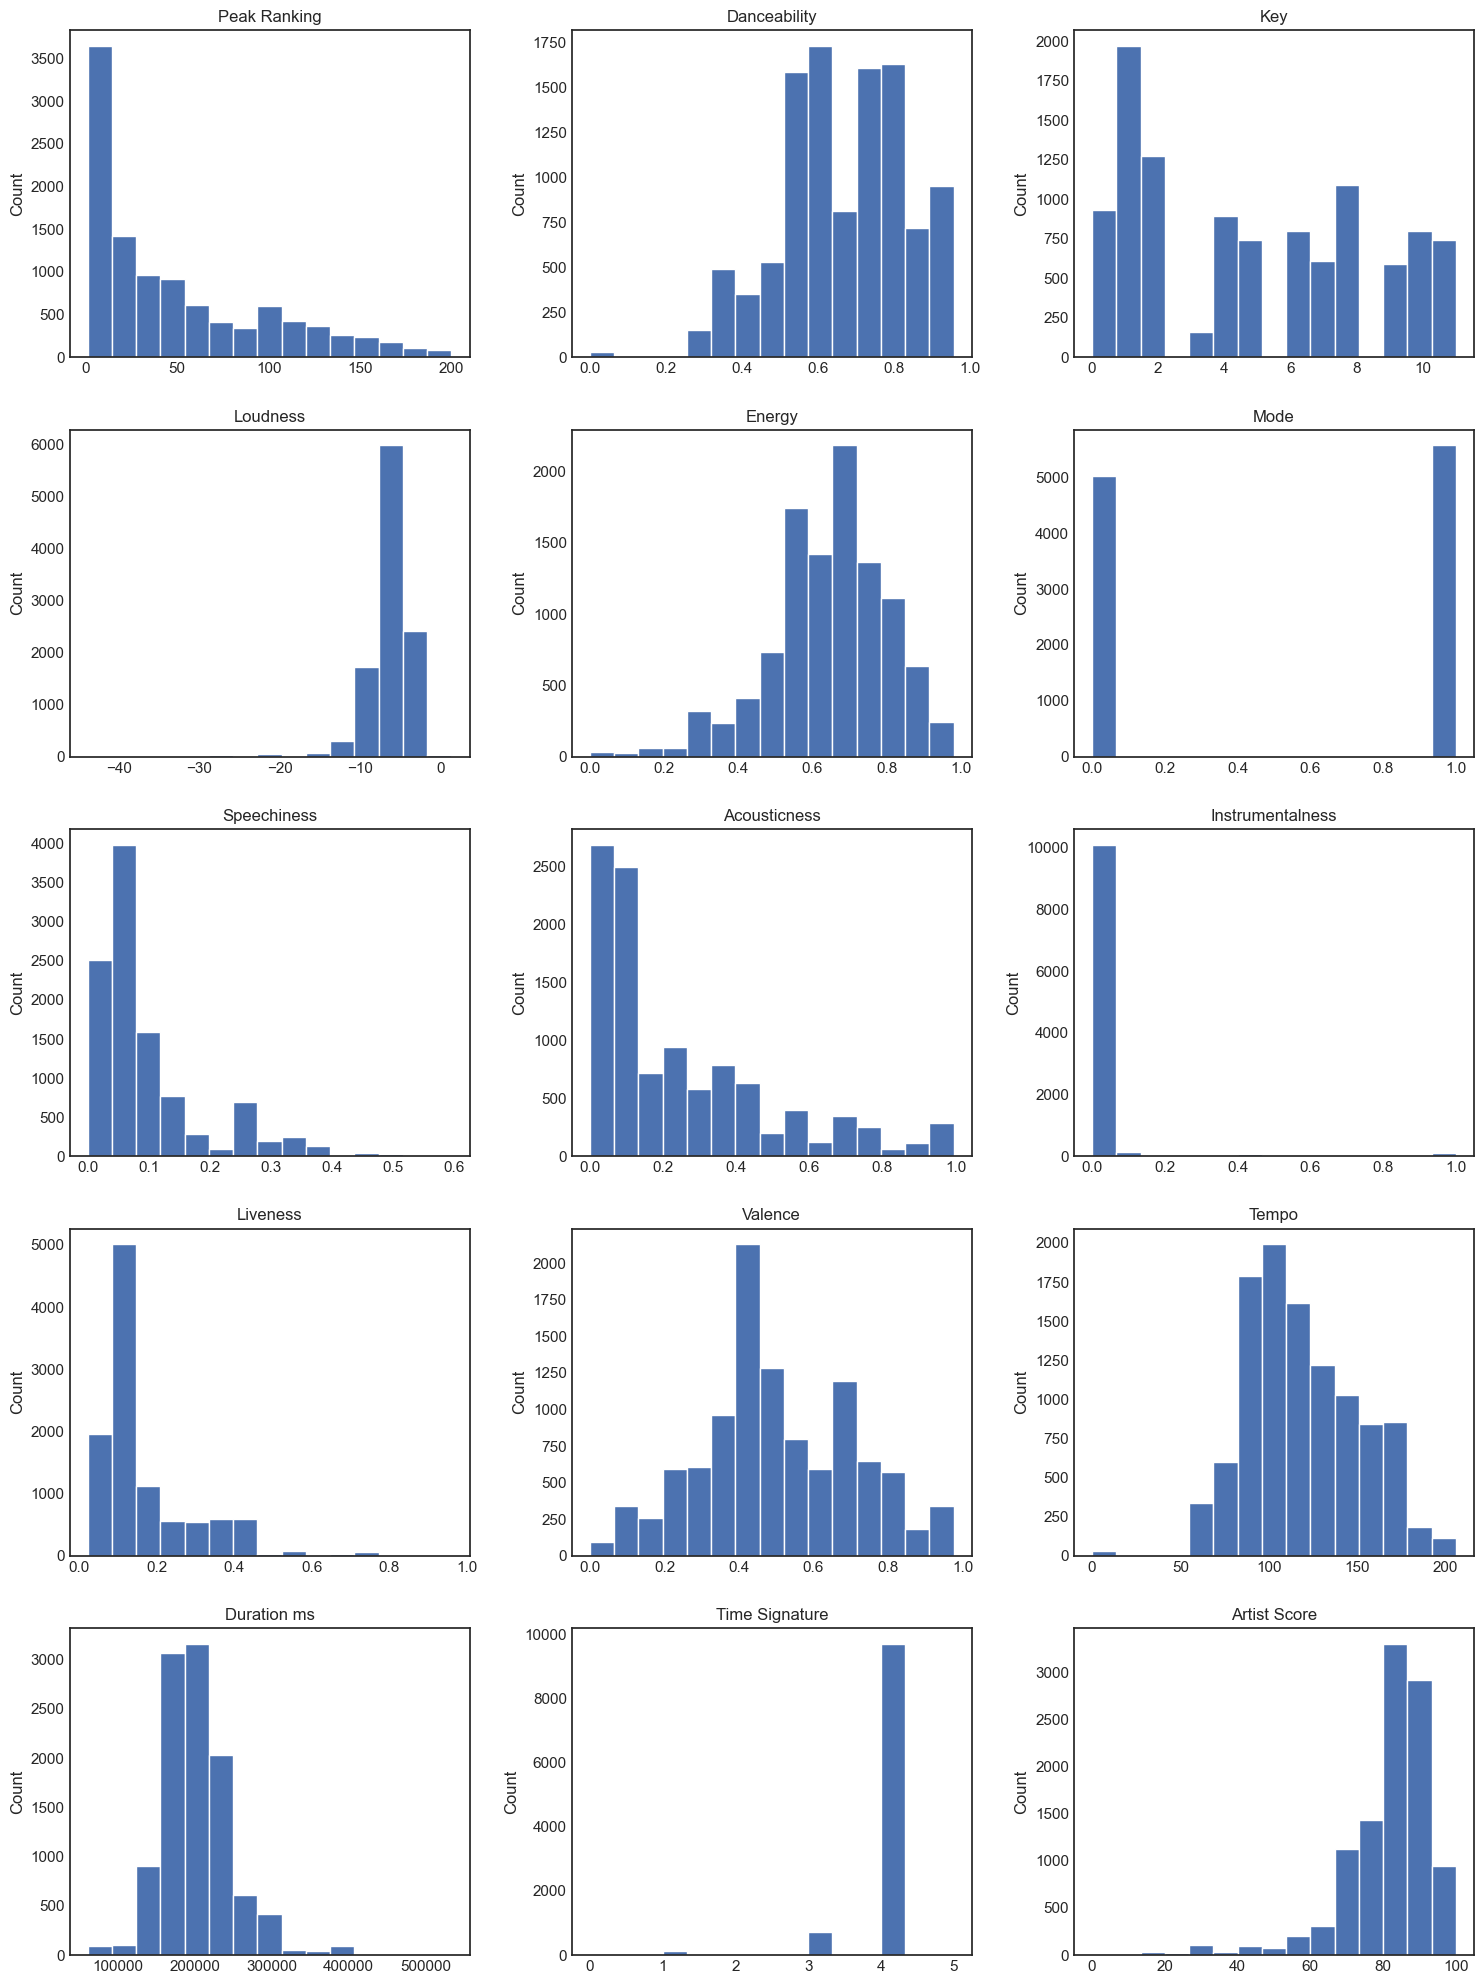

In [127]:
#EDA

dataset = df[variable_list]

plt.style.use("seaborn-v0_8-white")
fig, axes = plt.subplots(len(dataset.columns) // 3 ,3, figsize=(15, 20))
for i, col in enumerate(dataset.columns):
    # plt.figure(i)
    axes[i // 3][i % 3].hist(df[col], bins = 'sturges')
    axes[i // 3][i % 3].set_title(col)
    axes[i // 3][i % 3].set_ylabel('Count')    

fig.tight_layout(w_pad = 2, h_pad = 2) # change padding 
plt.savefig('EDA.png', bbox_inches='tight', pad_inches=0.5, transparent = True)
plt.show()


### 3 Data Preprocessing

#### 3.1 VIF Calculations

In [128]:
variable_list = [
        'Key', 'Loudness', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo','Artist Score']

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

x = df[variable_list]

calc_vif(x)

,variables,VIF
0,Key,3.061030
1,Loudness,8.764855
2,Mode,2.109285
3,Speechiness,2.227141
4,Acousticness,2.506727
5,Instrumentalness,1.333826
6,Liveness,2.735305
7,Valence,7.294366
8,Tempo,14.591085
9,Artist Score,15.752452


In [129]:
# Creating function to export tables

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

#### 3.2 Final Selected List of Features

<AxesSubplot: >

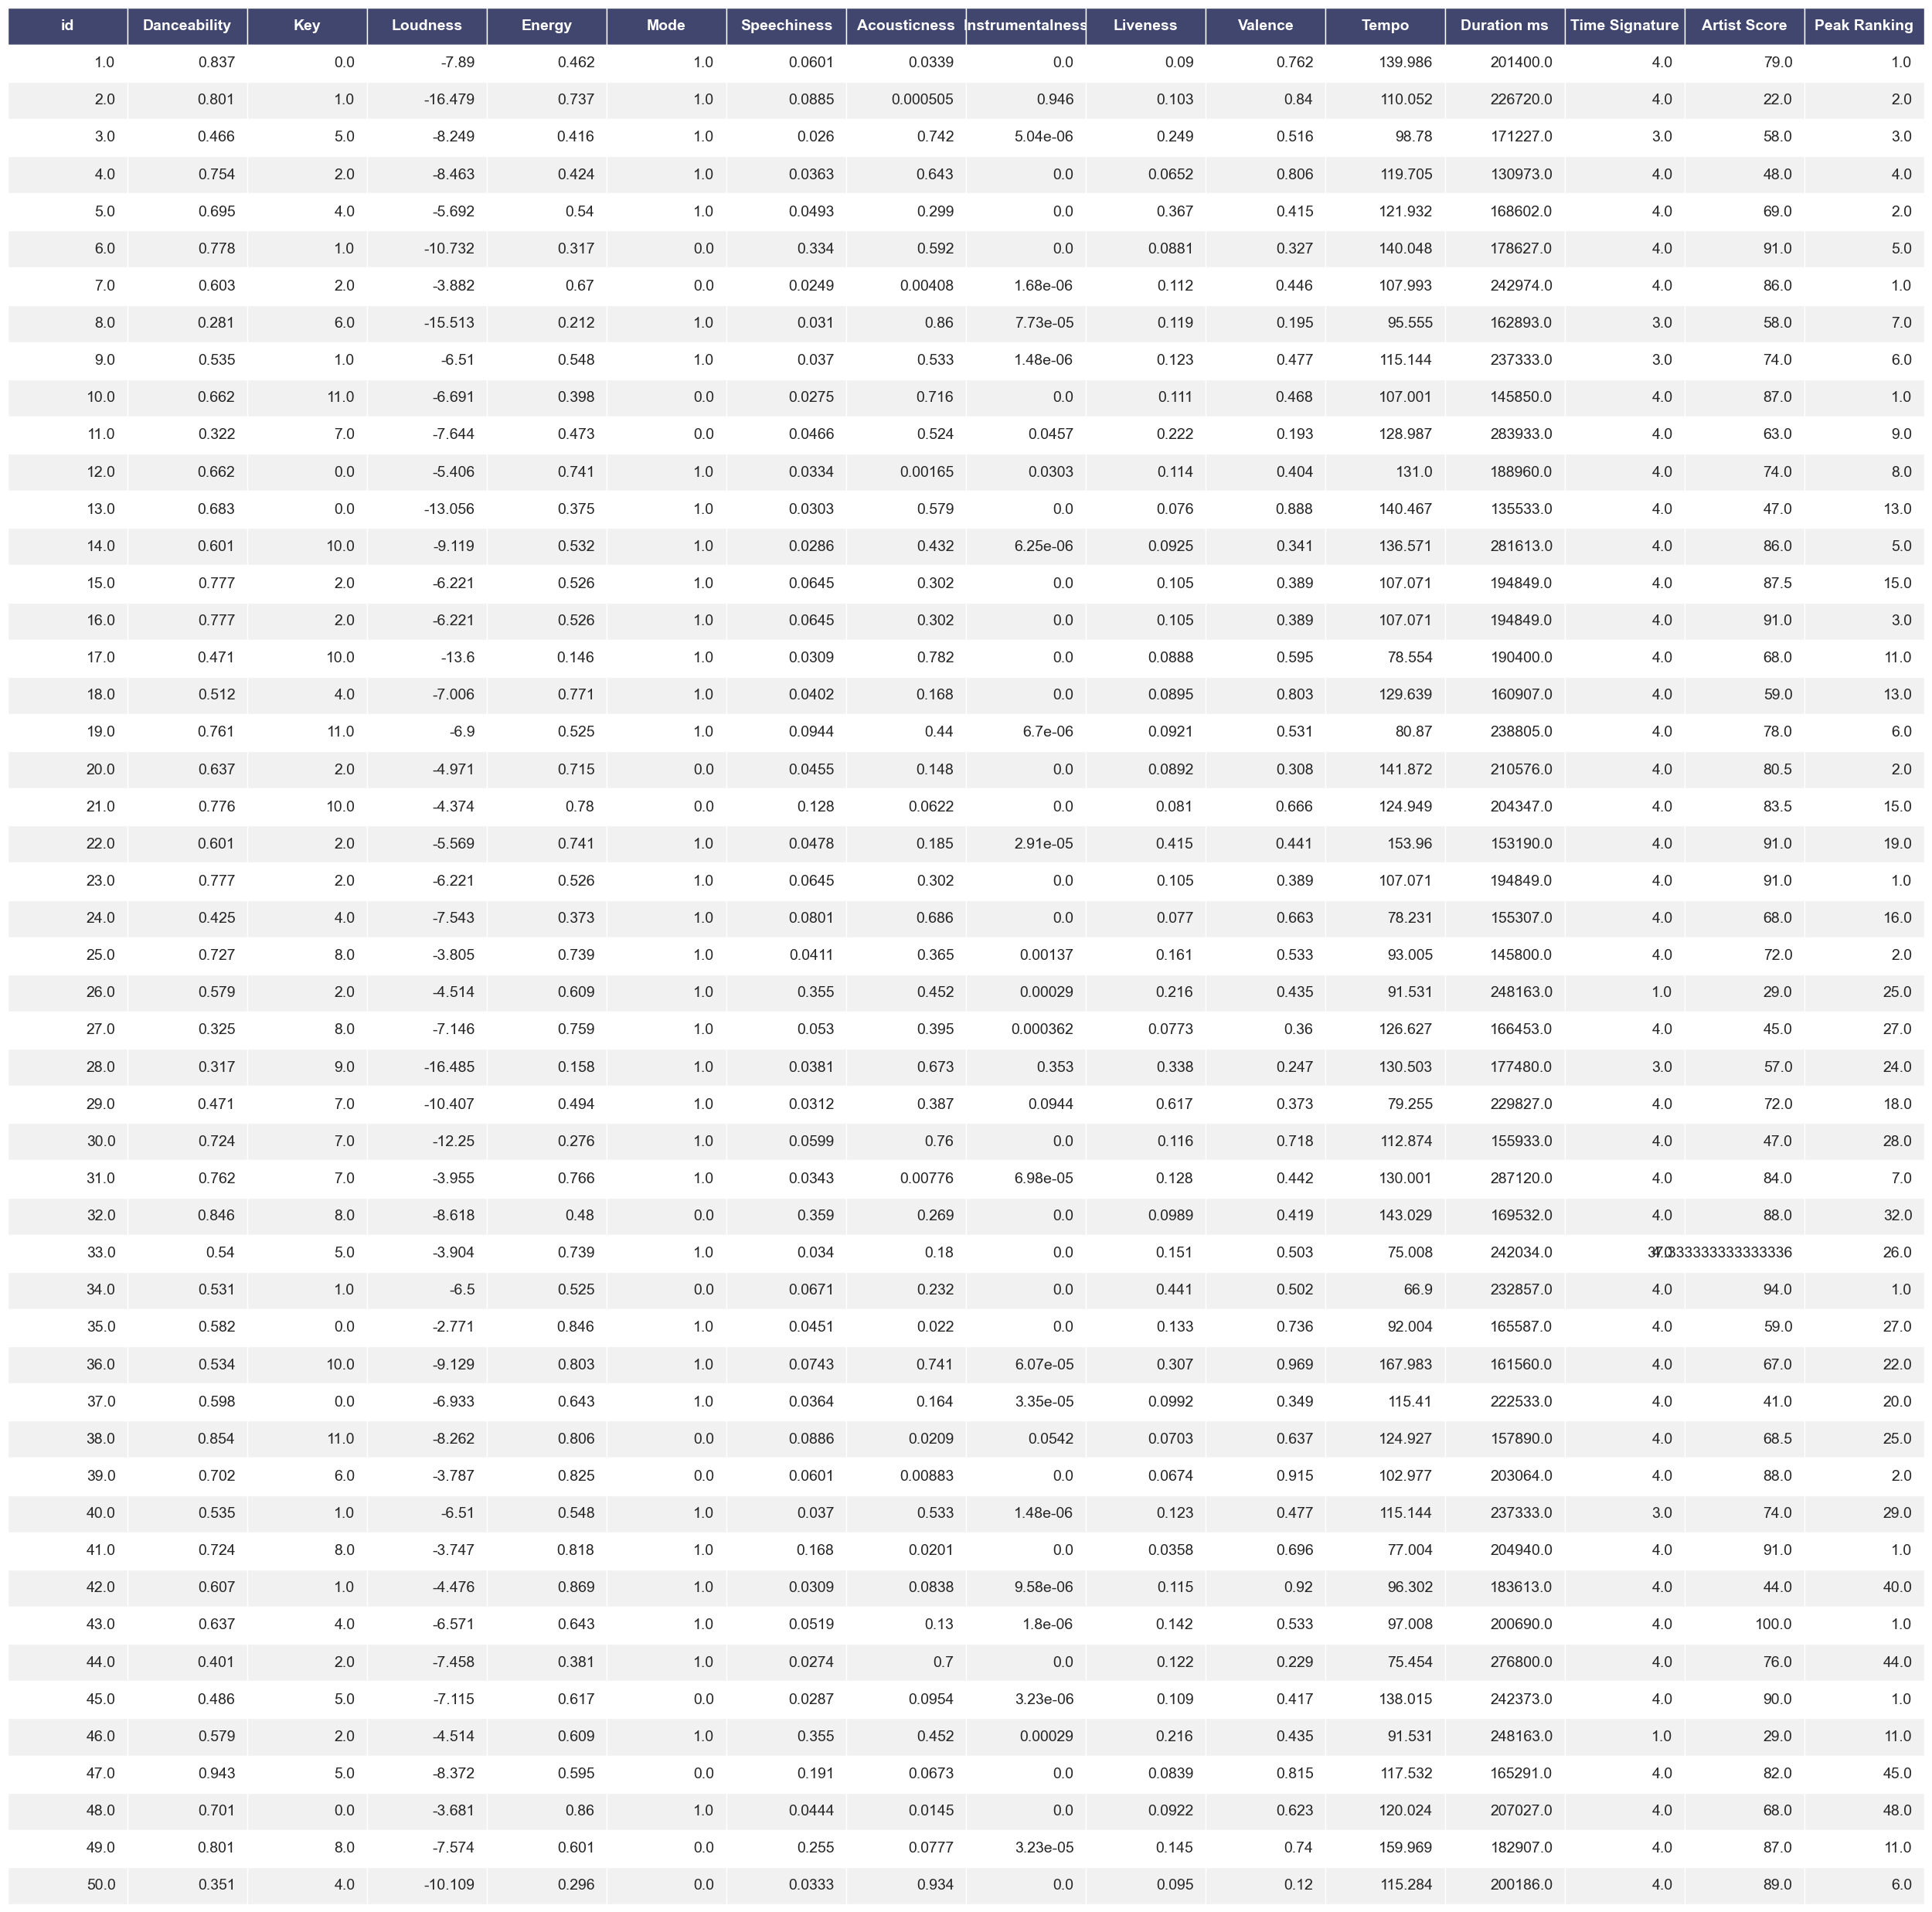

In [130]:
table_variable_list = ['id',
        'Danceability', 'Key', 'Loudness', 'Energy', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo', 'Duration ms', 'Time Signature','Artist Score','Peak Ranking']

table = df[table_variable_list]
render_mpl_table(table.head(50), header_columns=0, col_width=2.0)

#### 3.3 Selecting Dependent Variable

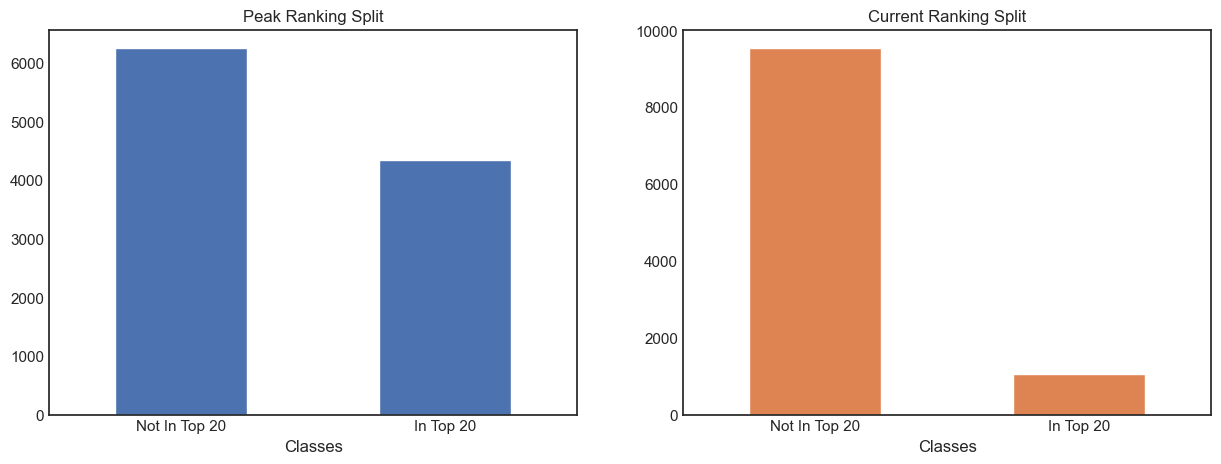

In [131]:
plt.style.use("seaborn-v0_8-white")
# training_split = pd.cut(y_train, bins=binner, labels=['In Top 20','Not In Top 20'])
# test_split = pd.cut(y_test, bins=binner, labels=['In Top 20','Not In Top 20'])
# training_split = training_split.value_counts().rename_axis('Classes').to_frame('Training Counts')
# test_split = test_split.value_counts().rename_axis('Classes').to_frame('Test Counts')


binner = [0,20,200]

peak_split = pd.cut(df['Peak Ranking'], bins=binner, labels=['In Top 20','Not In Top 20'])
current_split = pd.cut(df['Current Ranking'], bins=binner, labels=['In Top 20','Not In Top 20'])
peak_split = peak_split.value_counts().rename_axis('Classes').to_frame('Peak Ranking Split')
current_split = current_split.value_counts().rename_axis('Classes').to_frame('Current Ranking Split')

total_split = peak_split.merge(current_split, on = 'Classes')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
total_split.plot.bar(ax = axes, subplots = True, rot = 0, legend = None)
plt.savefig('Peak Ranking Splits.png', bbox_inches='tight', pad_inches=0.2, transparent = True)

#### 3.4 Splitting Data into Training Set and Test Set

In [132]:
variable_list = [
        'Danceability', 'Key', 'Loudness', 'Mode',  
        'Speechiness', 'Acousticness', 'Instrumentalness', 'Liveness', 
        'Valence', 'Tempo', 'Duration ms', 'Time Signature','Artist Score']

removed_variables = ['Number of weeks on billboard','Artist','Song Title','Current Ranking', 'Energy']


X = df[variable_list]
y = df['Peak Ranking']

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 109)

In [133]:
# Encode categorical features
#import label encoder
from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# cols = ['Artist', 'Song title']
# X_train[cols] = X_train[cols].apply(le.fit_transform)
# X_test[cols] = X_test[cols].apply(le.fit_transform)

# Scale continuous features
scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

X_train[variable_list] = scaler.fit_transform(X_train[variable_list])

X_test[variable_list] = scaler.fit_transform(X_test[variable_list])

#create 8 equal bins for y_test & y_train
bin_y_train = pd.cut(y_train, bins=8, labels=False)
# print(bin_y_train.value_counts())

bin_y_test = pd.cut(y_test, bins=8, labels=False)
# print(bin_y_test.value_counts())

binner = [0,20,200]

bin_y_train_2 = pd.cut(y_train, bins=binner, labels=[1,0])

bin_y_test_2 = pd.cut(y_test, bins=binner, labels=[1,0])

print(bin_y_test_2.value_counts())


0    1838
1    1342
Name: Peak Ranking, dtype: int64


In [134]:
# Use feature selection to select the most important features
# We dont actually do feature selection here, this code is not important
# selector = SelectKBest(f_classif, k='all')
# selector.fit(X_train, bin_y_train_2)
# X_train = selector.transform(X_train)
# X_val = selector.transform(X_test)

### 4 ML Models

#### 4.1 Logistics Regression

In [135]:
#Logistic Regression

# define the parameter grid to search over
param_grid = {'C': [0.1, 1, 10, 100]}

# perform a grid search over the parameter grid using cross-validation
lr_cv = GridSearchCV(LogisticRegression(random_state=109, multi_class='ovr'), param_grid, cv=5, scoring = 'f1_macro')
lr_cv.fit(X_train, bin_y_train_2)

# use the best hyperparameters to fit the model and make predictions on the test set
best_lr = lr_cv.best_estimator_
y_pred_lr = best_lr.predict(X_test)

# evaluate the performance of the model on the test set
print('Binary Logistic Regression Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_lr, average = 'binary'))
print('Precision:', precision_score(bin_y_test_2, y_pred_lr, average = 'binary'))
print('Recall:', recall_score(bin_y_test_2, y_pred_lr, average = 'binary'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_lr))

Binary Logistic Regression Scores:
F1 Score: 0.4403409090909091
Precision: 0.6038961038961039
Recall: 0.3464977645305514
Accuracy: 0.6283018867924528


#### 4.2 SVM

In [136]:
#Support Vector Machines

# Use GridSearchCV to find the best hyperparameters for SVM
svm = SVC(random_state=109)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['rbf'], 'decision_function_shape': ['ovr', 'ovo']}
grid_search = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
svm = grid_search.best_estimator_

# # reduce the number of features using PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=10)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

# Train the SVM model on the selected features
svm.fit(X_train, bin_y_train_2)
y_pred_svm = svm.predict(X_test)

# Evaluate the performance of the SVM model
print('Binary Support Vector Machine Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_svm, average = 'binary'))
print('Precision:', precision_score(bin_y_test_2, y_pred_svm, average = 'binary'))
print('Recall:', recall_score(bin_y_test_2, y_pred_svm, average = 'binary'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_svm))

Binary Support Vector Machine Scores:
F1 Score: 0.8241718238077902
Precision: 0.805693950177936
Recall: 0.8435171385991058
Accuracy: 0.8481132075471698


#### 4.3 Adaboost

In [137]:
#Adaboost

# Initialize the AdaBoost model
ada = AdaBoostClassifier(random_state=109)

# Define the hyperparameters to search over using GridSearchCV
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 500, 1000]}

# Use GridSearchCV to find the best hyperparameters for the model
grid_search = GridSearchCV(ada, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
ada = grid_search.best_estimator_

# Train the AdaBoost model on the selected features
ada.fit(X_train, bin_y_train_2)
y_pred_ada = ada.predict(X_test)

# Evaluate the performance of the AdaBoost model
print('Binary AdaBoost Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_ada, average='binary'))
print('Precision:', precision_score(bin_y_test_2, y_pred_ada, average='binary'))
print('Recall:', recall_score(bin_y_test_2, y_pred_ada, average='binary'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_ada))

Binary AdaBoost Scores:
F1 Score: 0.6536833192209992
Precision: 0.7568627450980392
Recall: 0.5752608047690015
Accuracy: 0.7427672955974842


#### 4.4 Gradient Boost

In [138]:
#Gradient Boosting

# Initialize the Gradient Boosting model
gboost = GradientBoostingClassifier(random_state = 109)

# Define the hyperparameters to search over using GridSearchCV
param_grid = {'learning_rate': [0.01, 0.1, 1],
              'n_estimators': [100, 500, 1000],
              'max_depth': [3, 5, 7]}

# Use GridSearchCV to find the best hyperparameters for the model
grid_search = GridSearchCV(gboost, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, bin_y_train_2)
gboost = grid_search.best_estimator_

# Train the Gradient Boosting model on the selected features
gboost.fit(X_train, bin_y_train_2)
y_pred_gboost = gboost.predict(X_test)

# Evaluate the performance of the Gradient Boosting model
print('Binary Gradient Boosting Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_gboost, average='binary'))
print('Precision:', precision_score(bin_y_test_2, y_pred_gboost, average='binary'))
print('Recall:', recall_score(bin_y_test_2, y_pred_gboost, average='binary'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_gboost))

Binary Gradient Boosting Scores:
F1 Score: 0.7776859504132231
Precision: 0.87291280148423
Recall: 0.7011922503725783
Accuracy: 0.8308176100628931


#### 4.5 Random Forest

In [139]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Specify the hyperparameter grid
param_grid = {'n_estimators': [100, 150, 200],
              'max_depth': [None, 5, 10],
              'min_samples_split': [4, 5, 6],
              'min_samples_leaf': [1, 2, 4]}
# Instantiate the GridSearchCV object
grid_search_rfc = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search_rfc.fit(X_train, bin_y_train_2)
print('Best Hyper Parameters:', grid_search_rfc.best_params_)

Best Hyper Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 150}


In [140]:
# Random Forest
rfc = RandomForestClassifier(max_depth=grid_search_rfc.best_params_['max_depth'], min_samples_leaf= grid_search_rfc.best_params_['min_samples_leaf'],
                              min_samples_split=grid_search_rfc.best_params_['min_samples_split'], n_estimators=grid_search_rfc.best_params_['n_estimators'], random_state=109)
rfc.fit(X_train, bin_y_train_2)
y_pred_rfc = rfc.predict(X_test)
# Evaluate the performance of the Random Forest model
print('Binary Random Forest Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_rfc, average='binary'))
print('Precision:', precision_score(bin_y_test_2, y_pred_rfc, average='binary'))
print('Recall:', recall_score(bin_y_test_2, y_pred_rfc, average='binary'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_rfc))

Binary Random Forest Scores:
F1 Score: 0.8654411764705883
Precision: 0.8541364296081277
Recall: 0.8770491803278688
Accuracy: 0.8849056603773585


#### 4.5.1 Getting Feature importances

In [141]:
feature_names = X.columns

importances = rfc.feature_importances_

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values('importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

             feature  importance
12      Artist Score    0.248190
10       Duration ms    0.086947
4        Speechiness    0.085953
0       Danceability    0.082000
2           Loudness    0.077722
8            Valence    0.076883
7           Liveness    0.075922
9              Tempo    0.072138
5       Acousticness    0.072073
6   Instrumentalness    0.052342
1                Key    0.051300
3               Mode    0.012882
11    Time Signature    0.005648


In [142]:
importance_df['cumulative_importance'] = importance_df['importance'].cumsum()
selected_features = importance_df[importance_df['cumulative_importance'] <= 0.95]['feature']
print(selected_features)

12        Artist Score
10         Duration ms
4          Speechiness
0         Danceability
2             Loudness
8              Valence
7             Liveness
9                Tempo
5         Acousticness
6     Instrumentalness
Name: feature, dtype: object


In [143]:
threshold = 0.03  # Choose an appropriate threshold value
selected_features = importance_df.loc[importance_df['importance'] >= threshold, 'feature']
print(selected_features)

12        Artist Score
10         Duration ms
4          Speechiness
0         Danceability
2             Loudness
8              Valence
7             Liveness
9                Tempo
5         Acousticness
6     Instrumentalness
1                  Key
Name: feature, dtype: object


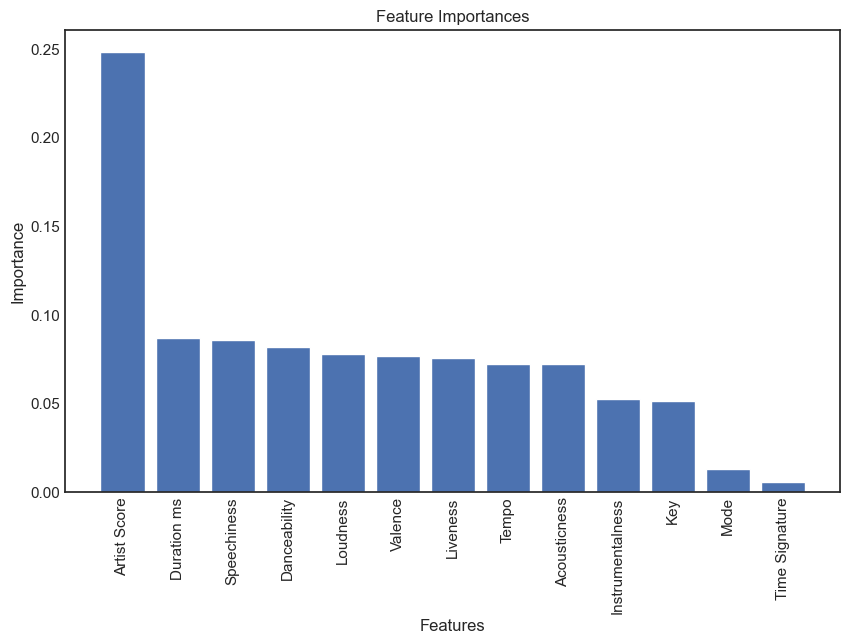

In [144]:
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')

#plt.savefig('Feature Importance.png')
plt.show()

#### 4.6 Naive Bayes

In [145]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# Define the parameter grid to search over
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Create a GridSearchCV object with 5-fold cross-validation
grid_search_NB = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object on the training data
grid_search_NB.fit(X_train, bin_y_train_2)

# Get the best hyperparameters
best_params_NB = grid_search_NB.best_params_
print(f"Best hyperparameters: {best_params_NB}")

Best hyperparameters: {'var_smoothing': 1e-09}


In [146]:
nb = GaussianNB(var_smoothing=1e-09)
nb.fit(X_train, bin_y_train_2)
y_pred_nb = nb.predict(X_test)
# Evaluate the performance of the Naive Bayes model
print('Binary Naive Bayes Scores:')
print('F1 Score:', f1_score(bin_y_test_2, y_pred_nb, average='binary'))
print('Precision:', precision_score(bin_y_test_2, y_pred_nb, average='binary'))
print('Recall:', recall_score(bin_y_test_2, y_pred_nb, average='binary'))
print('Accuracy:', accuracy_score(bin_y_test_2, y_pred_nb))

Binary Naive Bayes Scores:
F1 Score: 0.5955649419218585
Precision: 0.5643762508338893
Recall: 0.6304023845007451
Accuracy: 0.6386792452830189


### 5 Summary table

C:\Users\shayer\AppData\Local\Temp\ipykernel_18344\2863707362.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append({
C:\Users\shayer\AppData\Local\Temp\ipykernel_18344\2863707362.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append({
C:\Users\shayer\AppData\Local\Temp\ipykernel_18344\2863707362.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append({
C:\Users\shayer\AppData\Local\Temp\ipykernel_18344\2863707362.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  summary = summary.append({
C:\Users\shayer\AppData\Local\Temp\ipykernel_18344\2863707362.py:35: FutureWa

<AxesSubplot: >

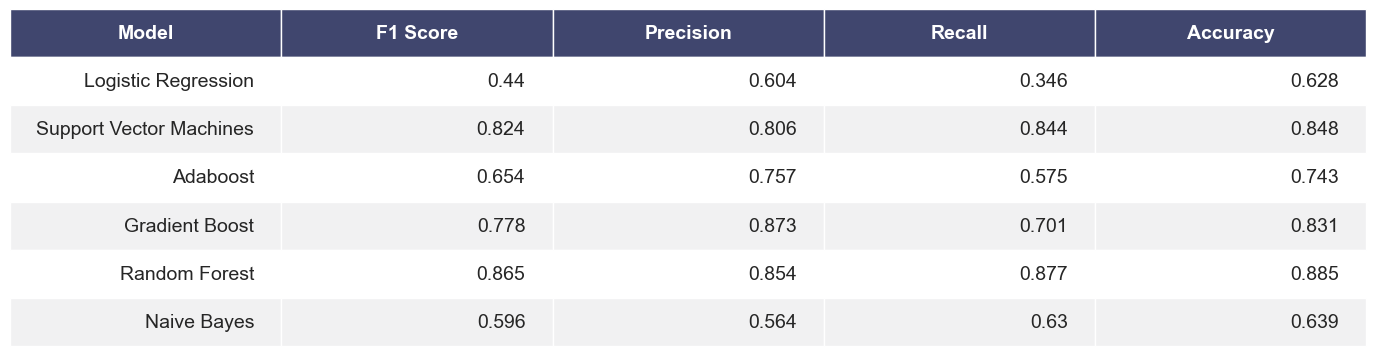

In [147]:
summary = pd.DataFrame([], columns=['Model','F1 Score', 'Precision', 'Recall', 'Accuracy'])

summary = summary.append({
    'Model': 'Logistic Regression',
    'F1 Score': round(f1_score(bin_y_test_2, y_pred_lr, average = 'binary'), 3),
    'Precision': round(precision_score(bin_y_test_2, y_pred_lr, average = 'binary'), 3),
    'Recall': round(recall_score(bin_y_test_2, y_pred_lr, average = 'binary'), 3),
    'Accuracy': round(accuracy_score(bin_y_test_2, y_pred_lr), 3)
                }, ignore_index = True)

summary = summary.append({
    'Model': 'Support Vector Machines',
    'F1 Score': round(f1_score(bin_y_test_2, y_pred_svm, average = 'binary'), 3),
    'Precision': round(precision_score(bin_y_test_2, y_pred_svm, average = 'binary'), 3),
    'Recall': round(recall_score(bin_y_test_2, y_pred_svm, average = 'binary'), 3),
    'Accuracy': round(accuracy_score(bin_y_test_2, y_pred_svm), 3)
                }, ignore_index = True)

summary = summary.append({
    'Model': 'Adaboost',
    'F1 Score': round(f1_score(bin_y_test_2, y_pred_ada, average = 'binary'), 3),
    'Precision': round(precision_score(bin_y_test_2, y_pred_ada, average = 'binary'), 3),
    'Recall': round(recall_score(bin_y_test_2, y_pred_ada, average = 'binary'), 3),
    'Accuracy': round(accuracy_score(bin_y_test_2, y_pred_ada), 3)
                }, ignore_index = True)

summary = summary.append({
    'Model': 'Gradient Boost',
    'F1 Score': round(f1_score(bin_y_test_2, y_pred_gboost, average = 'binary'), 3),
    'Precision': round(precision_score(bin_y_test_2, y_pred_gboost, average = 'binary'), 3),
    'Recall': round(recall_score(bin_y_test_2, y_pred_gboost, average = 'binary'), 3),
    'Accuracy': round(accuracy_score(bin_y_test_2, y_pred_gboost), 3)
                }, ignore_index = True)

summary = summary.append({
    'Model': 'Random Forest',
    'F1 Score': round(f1_score(bin_y_test_2, y_pred_rfc, average = 'binary'), 3),
    'Precision': round(precision_score(bin_y_test_2, y_pred_rfc, average = 'binary'), 3),
    'Recall': round(recall_score(bin_y_test_2, y_pred_rfc, average = 'binary'), 3),
    'Accuracy': round(accuracy_score(bin_y_test_2, y_pred_rfc), 3)
                }, ignore_index = True)

summary = summary.append({
    'Model': 'Naive Bayes',
    'F1 Score': round(f1_score(bin_y_test_2, y_pred_nb, average = 'binary'), 3),
    'Precision': round(precision_score(bin_y_test_2, y_pred_nb, average = 'binary'), 3),
    'Recall': round(recall_score(bin_y_test_2, y_pred_nb, average = 'binary'), 3),
    'Accuracy': round(accuracy_score(bin_y_test_2, y_pred_nb), 3)
                }, ignore_index = True)

render_mpl_table(summary, header_columns=0, col_width=3.5)